In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, f1_score, accuracy_score

from catboost import CatBoostClassifier, Pool, metrics as catmetrics, cv

In [2]:
df_X = pd.read_csv('train/train_meta.csv', index_col=0)
df_y = pd.read_csv('train/train_gts.csv', index_col=0)
df = pd.merge(df_X, df_y, on='record_name', how='outer')
print(dict(df.dtypes))
df.head(8)

{'patient_id': dtype('float64'), 'age': dtype('float64'), 'sex': dtype('int64'), 'height': dtype('float64'), 'weight': dtype('float64'), 'nurse': dtype('float64'), 'site': dtype('float64'), 'device': dtype('O'), 'recording_date': dtype('O'), 'report': dtype('O'), 'scp_codes': dtype('O'), 'heart_axis': dtype('O'), 'infarction_stadium1': dtype('O'), 'infarction_stadium2': dtype('O'), 'validated_by': dtype('float64'), 'second_opinion': dtype('bool'), 'initial_autogenerated_report': dtype('bool'), 'validated_by_human': dtype('bool'), 'baseline_drift': dtype('O'), 'static_noise': dtype('O'), 'burst_noise': dtype('O'), 'electrodes_problems': dtype('O'), 'extra_beats': dtype('O'), 'pacemaker': dtype('O'), 'strat_fold': dtype('int64'), 'filename_lr': dtype('O'), 'filename_hr': dtype('O'), 'record_name': dtype('O'), 'group': dtype('int64'), 'myocard': dtype('int64')}


,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,record_name,group,myocard
0,18792.0,55.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-12-08 09:44:43,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,10,records100/00000/00009_lr,records500/00000/00009_hr,00009_hr,1,0
1,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-02-10 12:04:03,"erneut vorhofflattern unter 3x1 cordichin ,1x0...",...,NaN,NaN,NaN,NaN,9,records100/00000/00034_lr,records500/00000/00034_hr,00034_hr,3,0
2,11315.0,25.0,1,NaN,63.0,2.0,0.0,CS-12 E,1985-03-14 09:38:53,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,8,records100/00000/00043_lr,records500/00000/00043_hr,00043_hr,3,0
3,18153.0,35.0,0,NaN,82.0,2.0,0.0,CS-12 E,1985-05-18 08:15:54,sinusrhythmus unvollstÄndiger rechtsschenkelbl...,...,NaN,NaN,NaN,NaN,1,records100/00000/00052_lr,records500/00000/00052_hr,00052_hr,2,0
4,16063.0,26.0,0,NaN,93.0,2.0,0.0,CS-12 E,1985-06-06 11:32:43,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,10,records100/00000/00057_lr,records500/00000/00057_hr,00057_hr,3,0
5,14660.0,25.0,0,NaN,70.0,2.0,0.0,CS-12 E,1985-06-19 09:55:04,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,6,records100/00000/00061_lr,records500/00000/00061_hr,00061_hr,1,0
6,20961.0,46.0,1,NaN,47.0,0.0,0.0,CS-12 E,1985-10-24 11:41:07,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,5,records100/00000/00081_lr,records500/00000/00081_hr,00081_hr,2,0
7,21698.0,31.0,0,NaN,62.0,2.0,0.0,CS-12 E,1985-12-02 12:13:46,sinusrhythmus unspezifische intraventrikulÄre ...,...,NaN,NaN,1ES,NaN,1,records100/00000/00096_lr,records500/00000/00096_hr,00096_hr,2,0


In [3]:
imd = []
for fn in df['record_name']:
    with open(f"train/{fn}.npy", "rb") as f:
        data = np.load(f, allow_pickle=True)
        imd.append([fn, data])
signals = pd.DataFrame(imd, columns=["record_name","signal"])
signals.head()

,record_name,signal
0,00009_hr,"[[-0.12, -0.12, -0.12, -0.12, -0.121, -0.12, -..."
1,00034_hr,"[[0.935, 0.935, 0.936, 0.932, 0.941, 0.935, 0...."
2,00043_hr,"[[-0.005, -0.005, -0.005, -0.005, -0.004, -0.0..."
3,00052_hr,"[[-0.025, -0.025, -0.025, -0.025, -0.025, -0.0..."
4,00057_hr,"[[-0.155, -0.155, -0.155, -0.156, -0.153, -0.1..."


In [15]:
import tensorflow as tf
model = tf.keras.models.load_model("second_cv_model.ckpt")

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xce in position 66: invalid continuation byte

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 12, 991, 16)       816       
                                                                 
 conv2d_16 (Conv2D)          (None, 12, 982, 32)       5152      
                                                                 
 flatten_3 (Flatten)         (None, 377088)            0         
                                                                 
 dense_6 (Dense)             (None, 32)                12066848  
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 12,072,849
Trainable params: 12,072,849
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# TEST PART

In [ ]:
new_X = pd.read_csv('test/test_meta.csv', index_col=0)

In [ ]:
print(dict(new_X.dtypes))
new_X.head(4)

{'patient_id': dtype('float64'), 'age': dtype('float64'), 'sex': dtype('int64'), 'height': dtype('float64'), 'weight': dtype('float64'), 'nurse': dtype('float64'), 'site': dtype('float64'), 'device': dtype('O'), 'recording_date': dtype('O'), 'report': dtype('O'), 'scp_codes': dtype('O'), 'heart_axis': dtype('O'), 'infarction_stadium1': dtype('O'), 'infarction_stadium2': dtype('O'), 'validated_by': dtype('float64'), 'second_opinion': dtype('bool'), 'initial_autogenerated_report': dtype('bool'), 'validated_by_human': dtype('bool'), 'baseline_drift': dtype('O'), 'static_noise': dtype('O'), 'burst_noise': dtype('O'), 'electrodes_problems': dtype('O'), 'extra_beats': dtype('O'), 'pacemaker': dtype('O'), 'strat_fold': dtype('int64'), 'filename_lr': dtype('O'), 'filename_hr': dtype('O'), 'record_name': dtype('O'), 'group': dtype('int64')}


,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,record_name,group
ecg_id,,,,,,,,,,,,,,,,,,,,,
127,11926.0,22.0,1,NaN,52.0,0.0,0.0,CS-12 E,1986-01-30 13:10:31,sinusrhythmus unspezifisches abnormales t,...,", I-AVR,",NaN,NaN,NaN,NaN,9,records100/00000/00127_lr,records500/00000/00127_hr,00127_hr,1
186,12396.0,60.0,1,NaN,NaN,NaN,3.0,AT-6 C,1986-03-19 14:07:42,sinusbradykardi lÅga qrs amplituder i extremit...,...,NaN,NaN,NaN,NaN,NaN,9,records100/00000/00186_lr,records500/00000/00186_hr,00186_hr,2
193,17536.0,28.0,0,NaN,112.0,0.0,0.0,CS-12 E,1986-03-22 09:24:13,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,NaN,9,records100/00000/00193_lr,records500/00000/00193_hr,00193_hr,1
198,21074.0,19.0,1,NaN,59.0,0.0,0.0,CS-12 E,1986-04-18 10:52:02,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,NaN,9,records100/00000/00198_lr,records500/00000/00198_hr,00198_hr,2


In [ ]:
cardiograms = []
for fn in new_X['record_name']:
    with open(f"test/{fn}.npy", "rb") as f:
        data = np.load(f, allow_pickle=True)
        cardiograms.append([fn, data])
new_signals = pd.DataFrame(cardiograms, columns=["record_name","signal"])
new_signals.head()

,record_name,signal
0,00127_hr,"[[0.105, 0.105, 0.105, 0.105, 0.105, 0.105, 0...."
1,00186_hr,"[[-0.005, -0.005, -0.005, -0.005, -0.005, -0.0..."
2,00193_hr,"[[0.055, 0.055, 0.055, 0.055, 0.055, 0.055, 0...."
3,00198_hr,"[[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.055, 0..."
4,00211_hr,"[[-0.09, -0.09, -0.09, -0.09, -0.09, -0.09, -0..."


In [ ]:
new_signals.isna().sum()

record_name    0
signal         0
dtype: int64

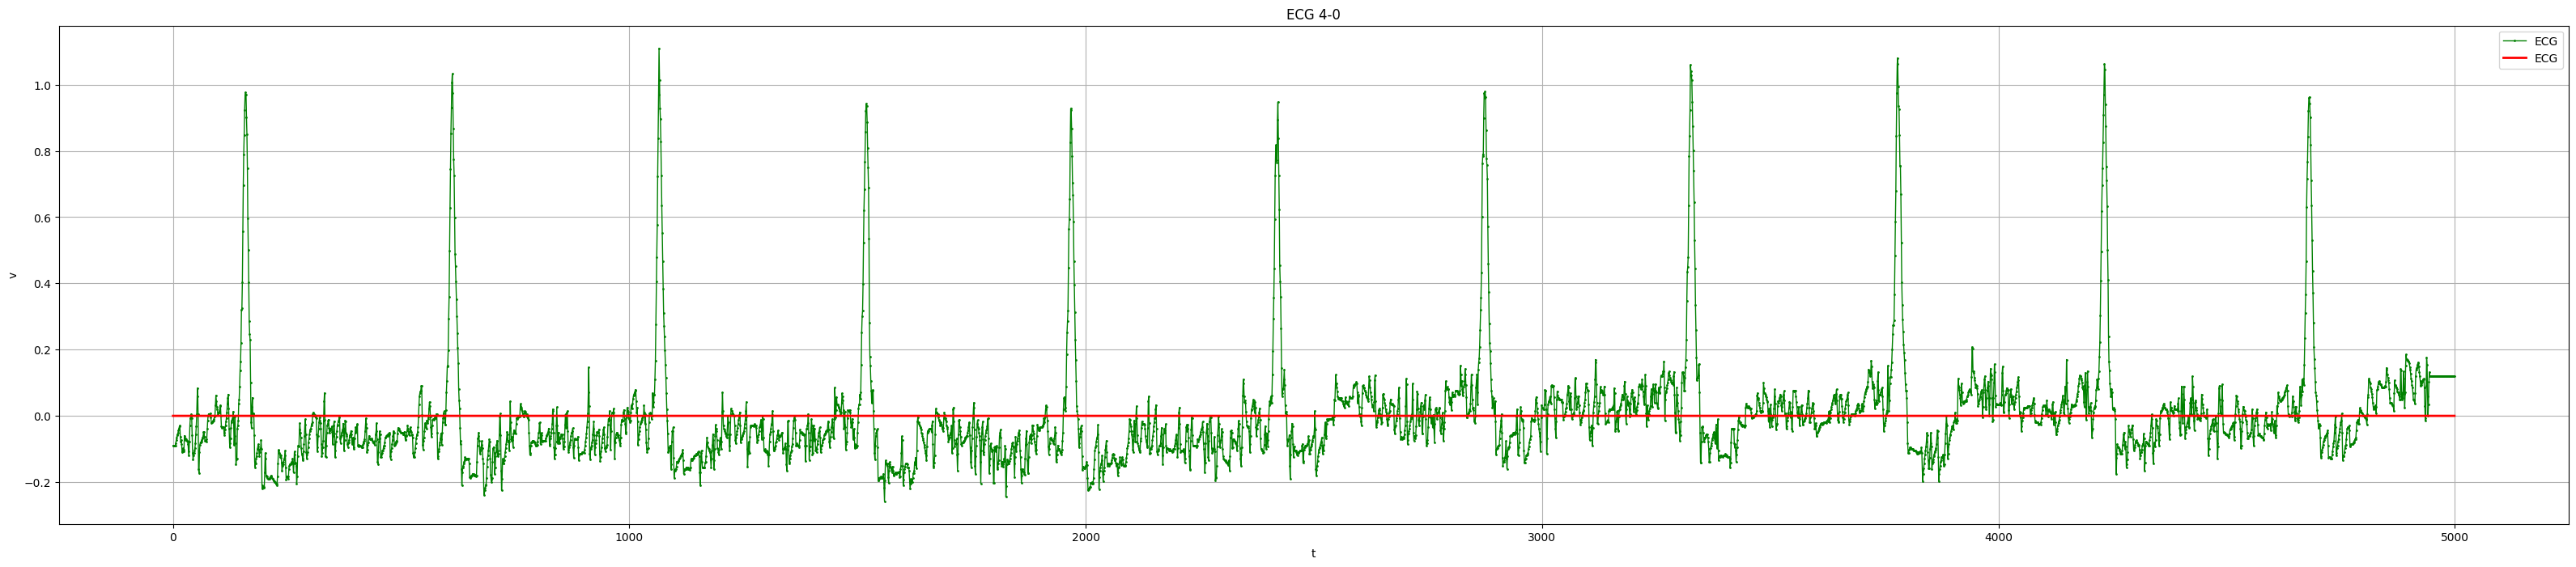

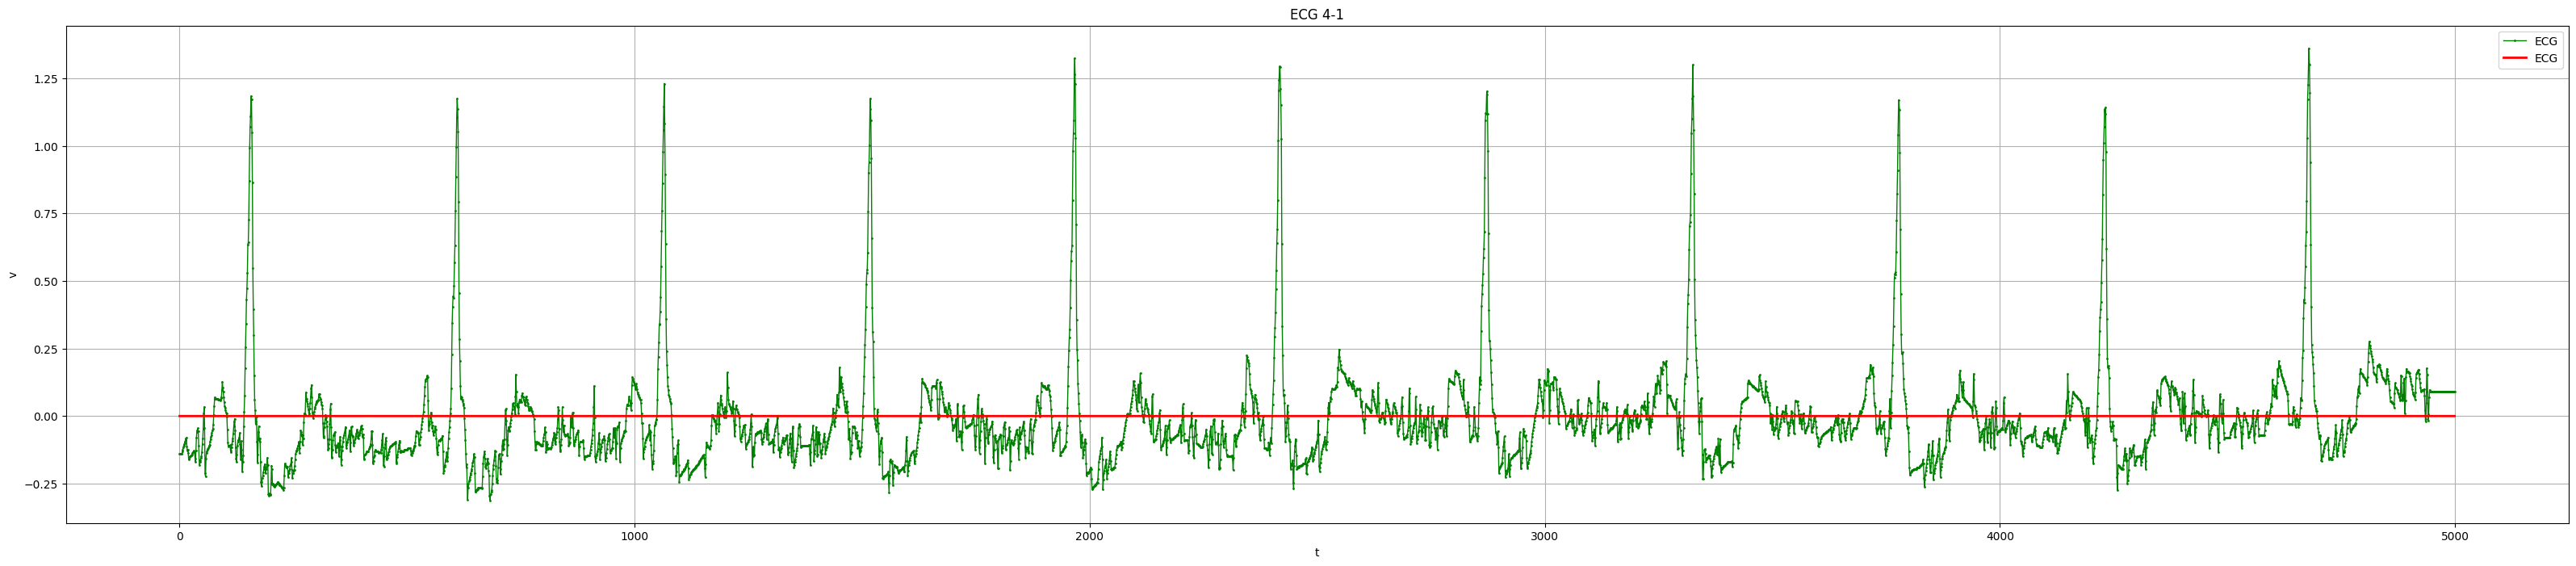

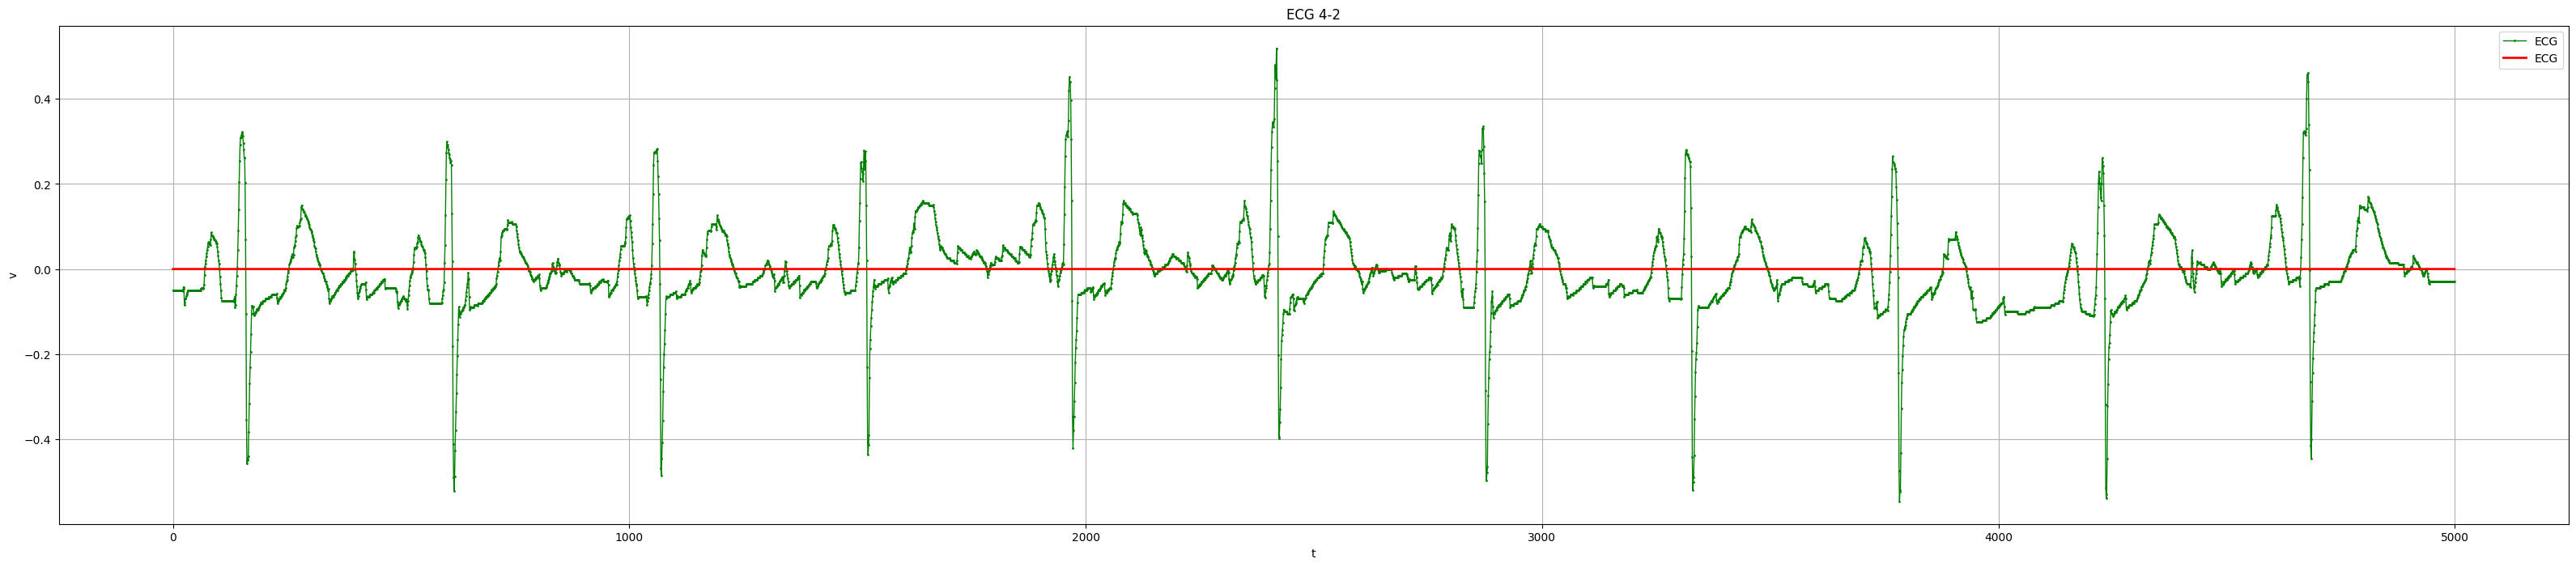

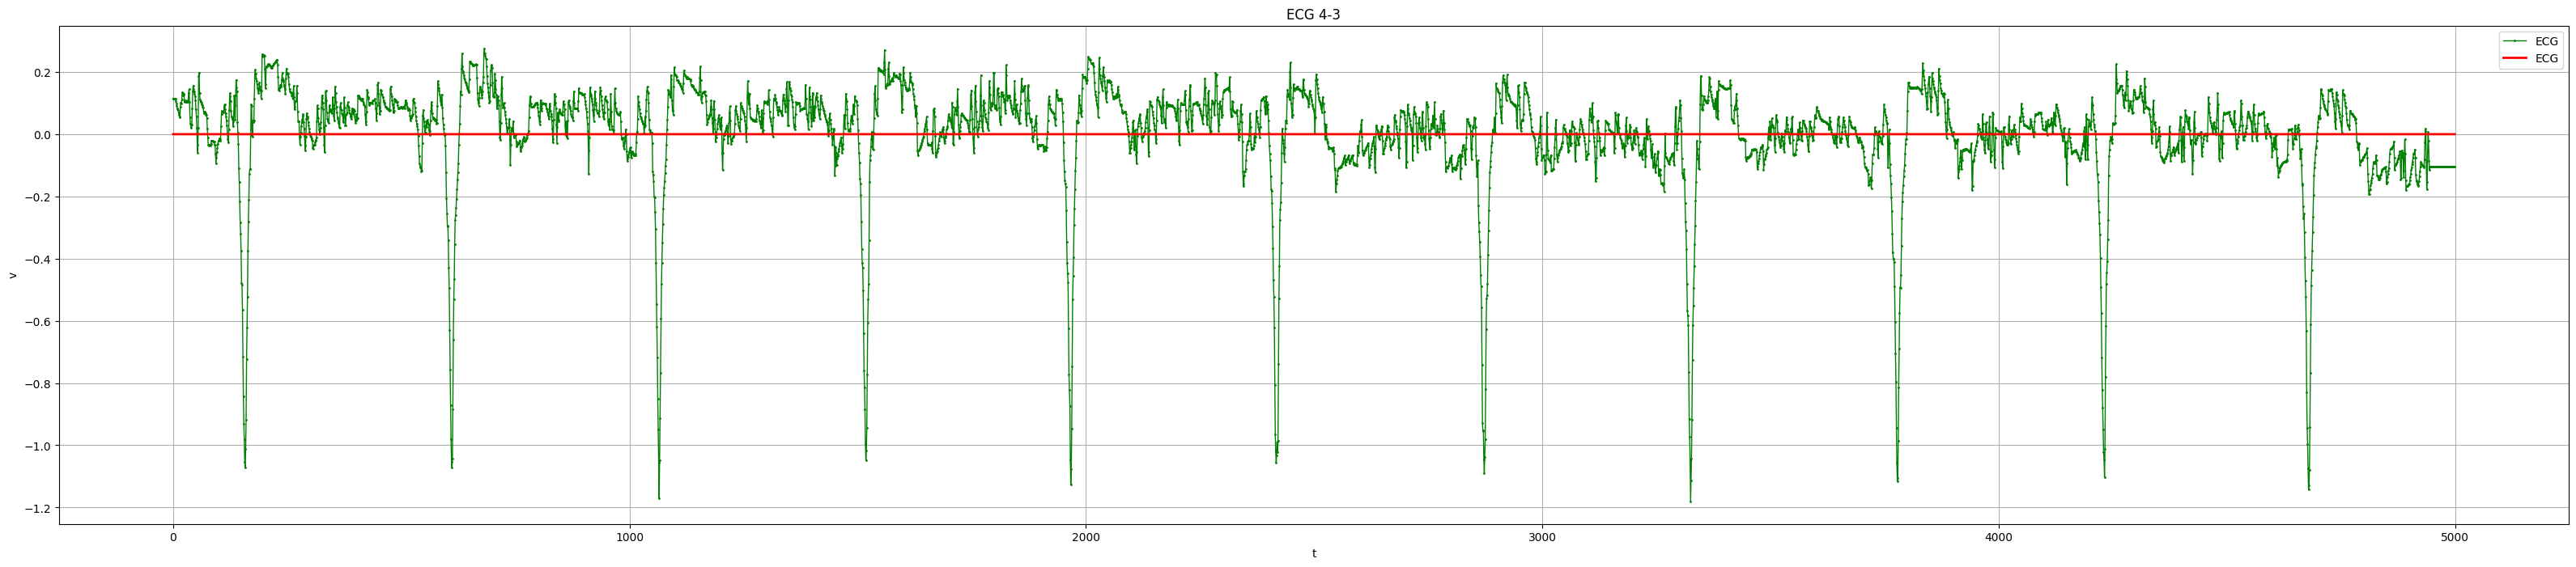

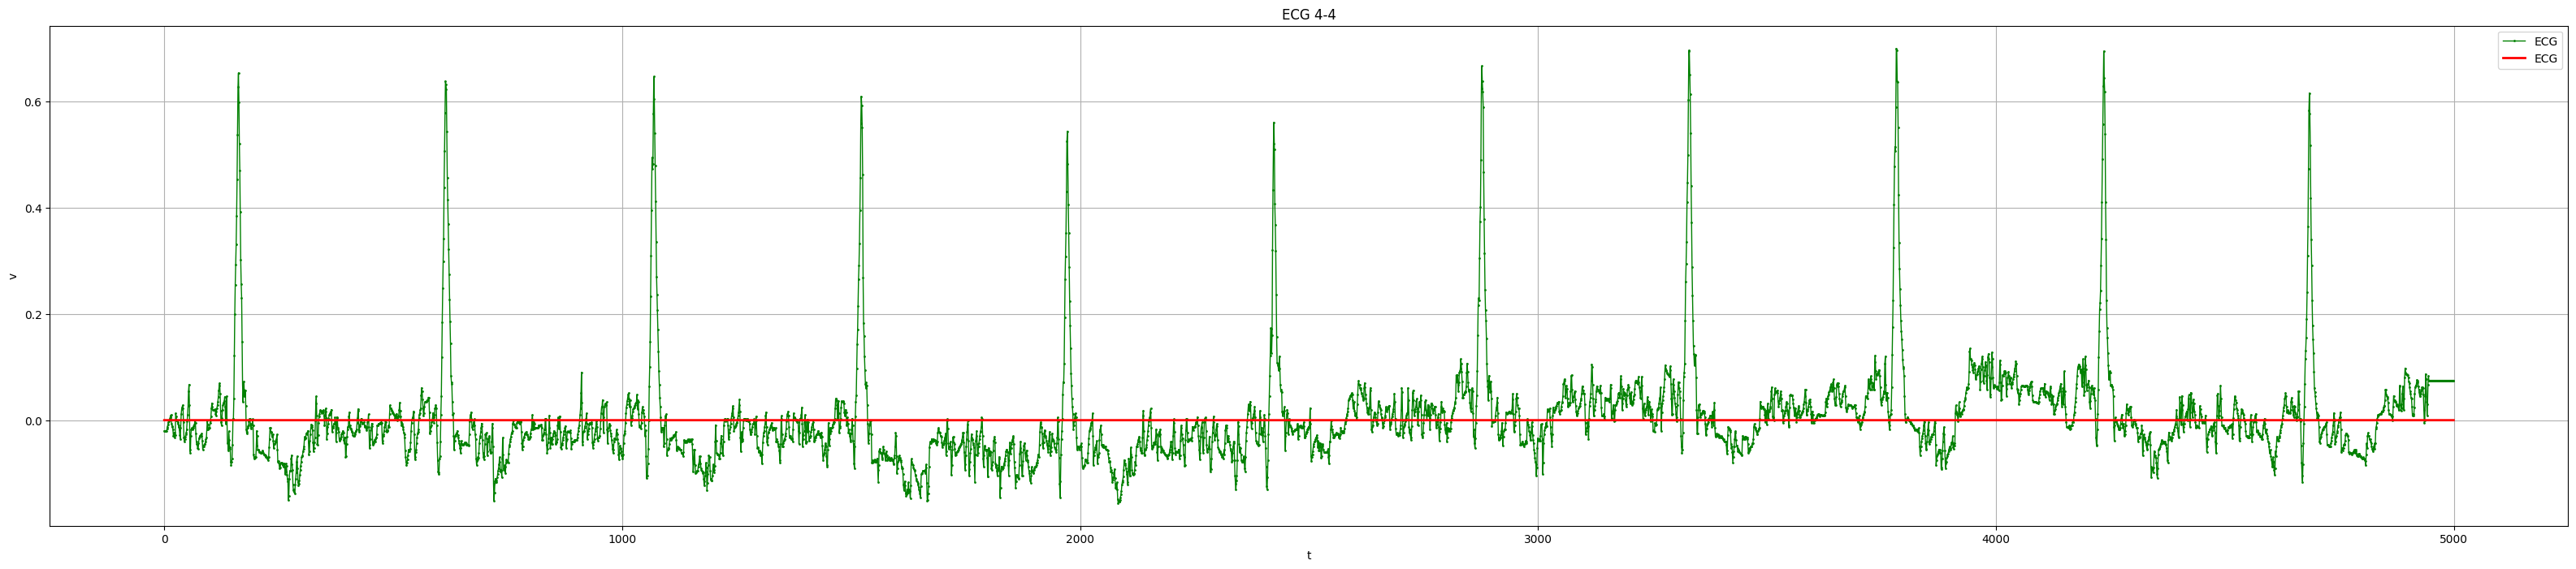

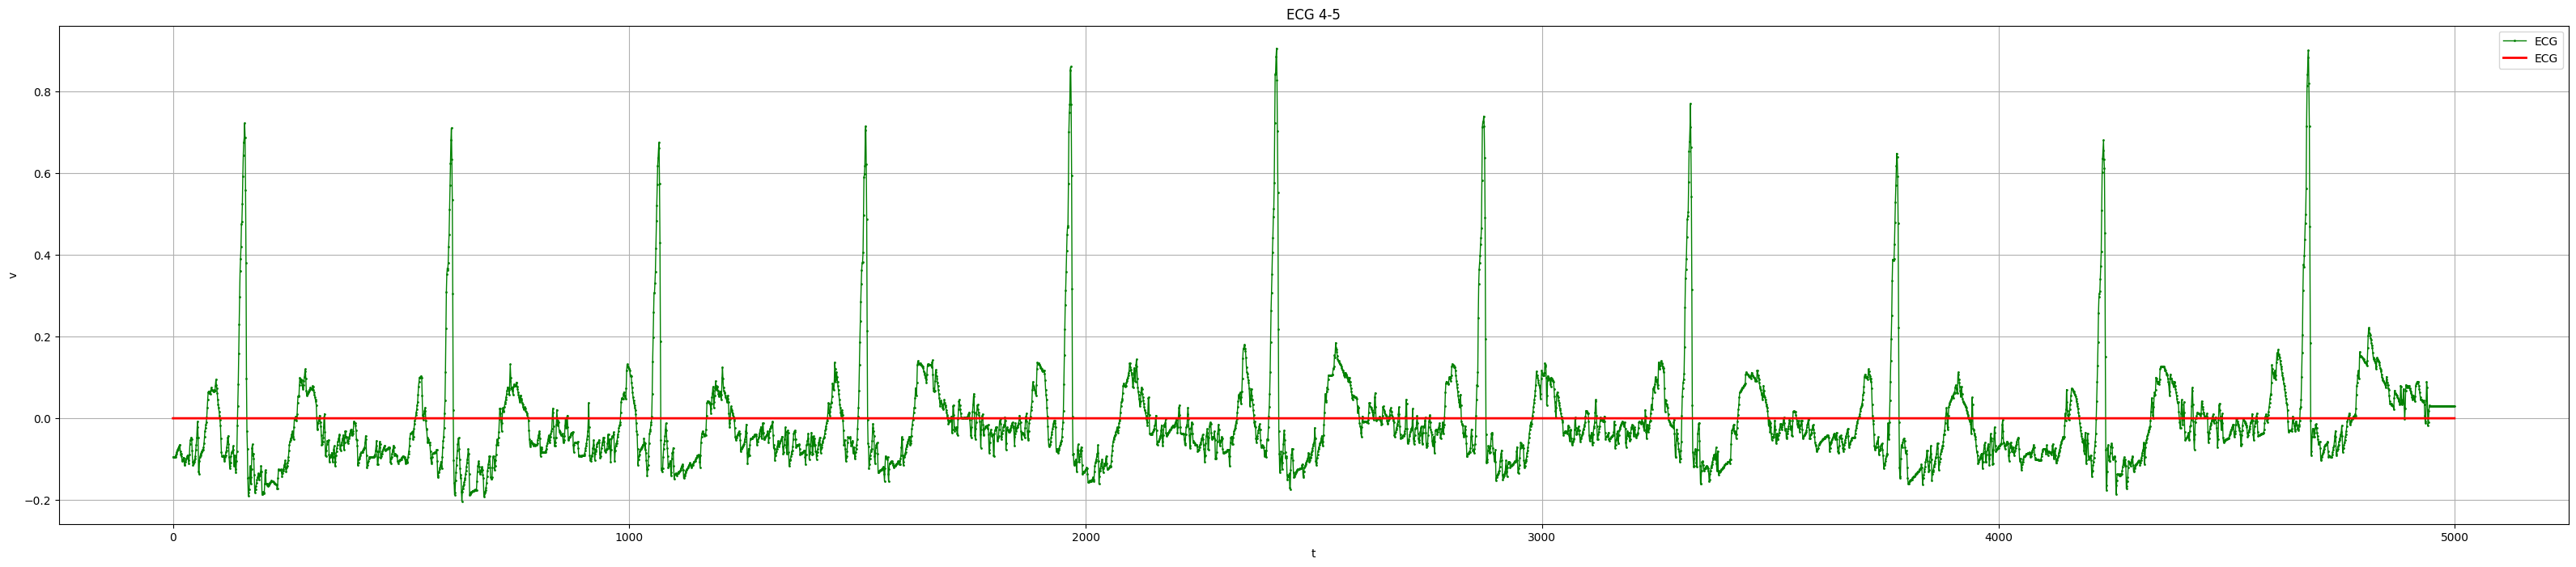

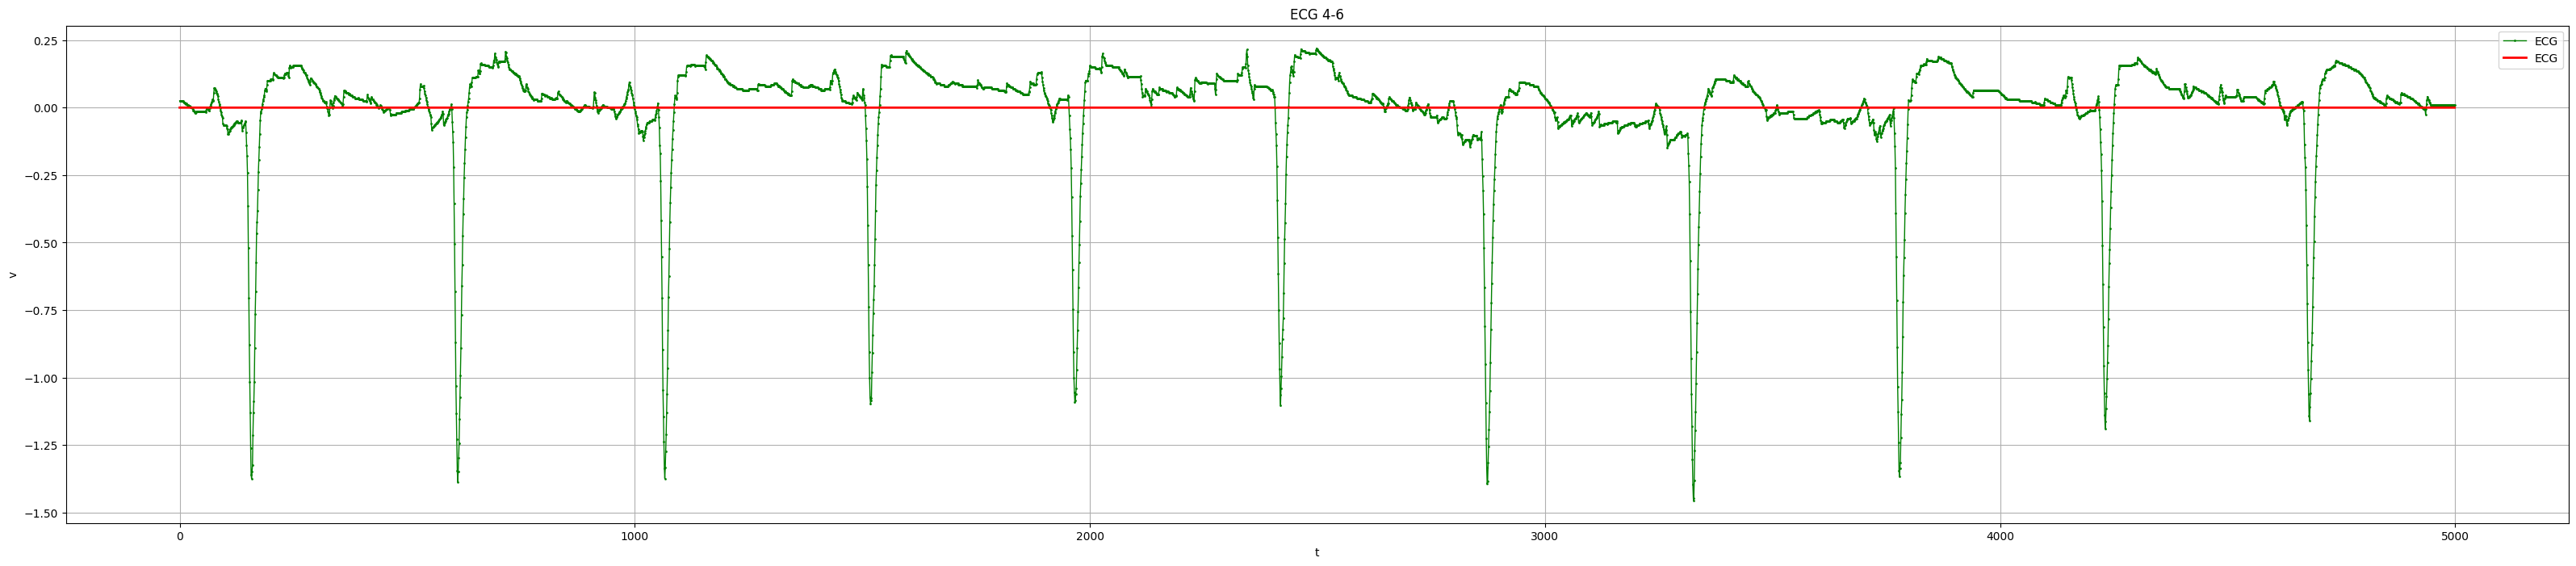

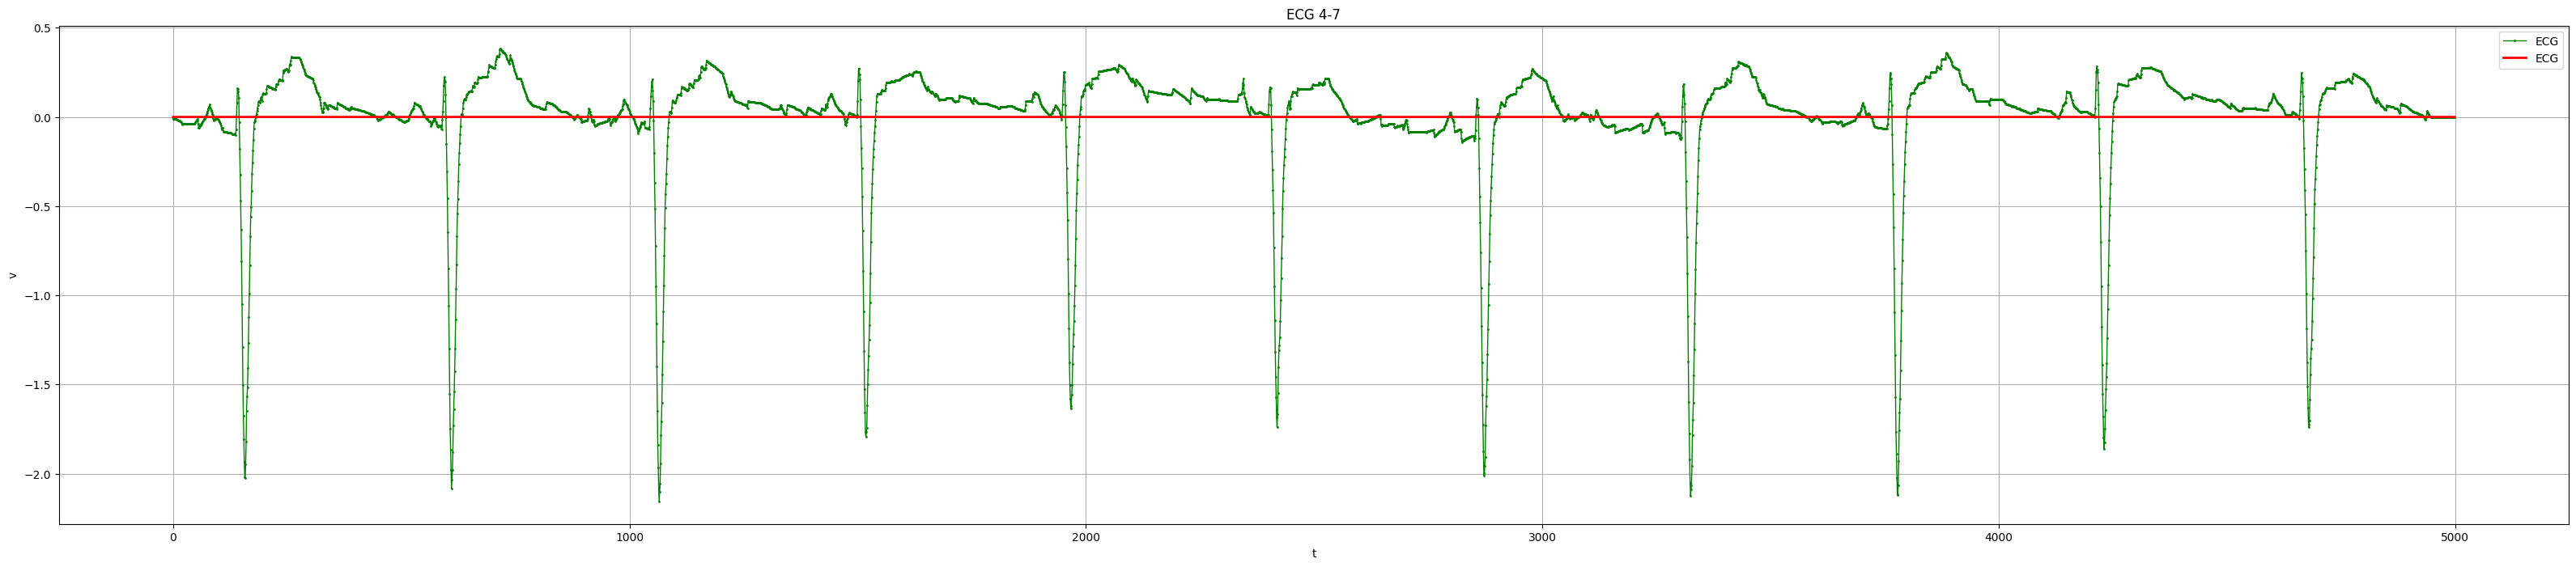

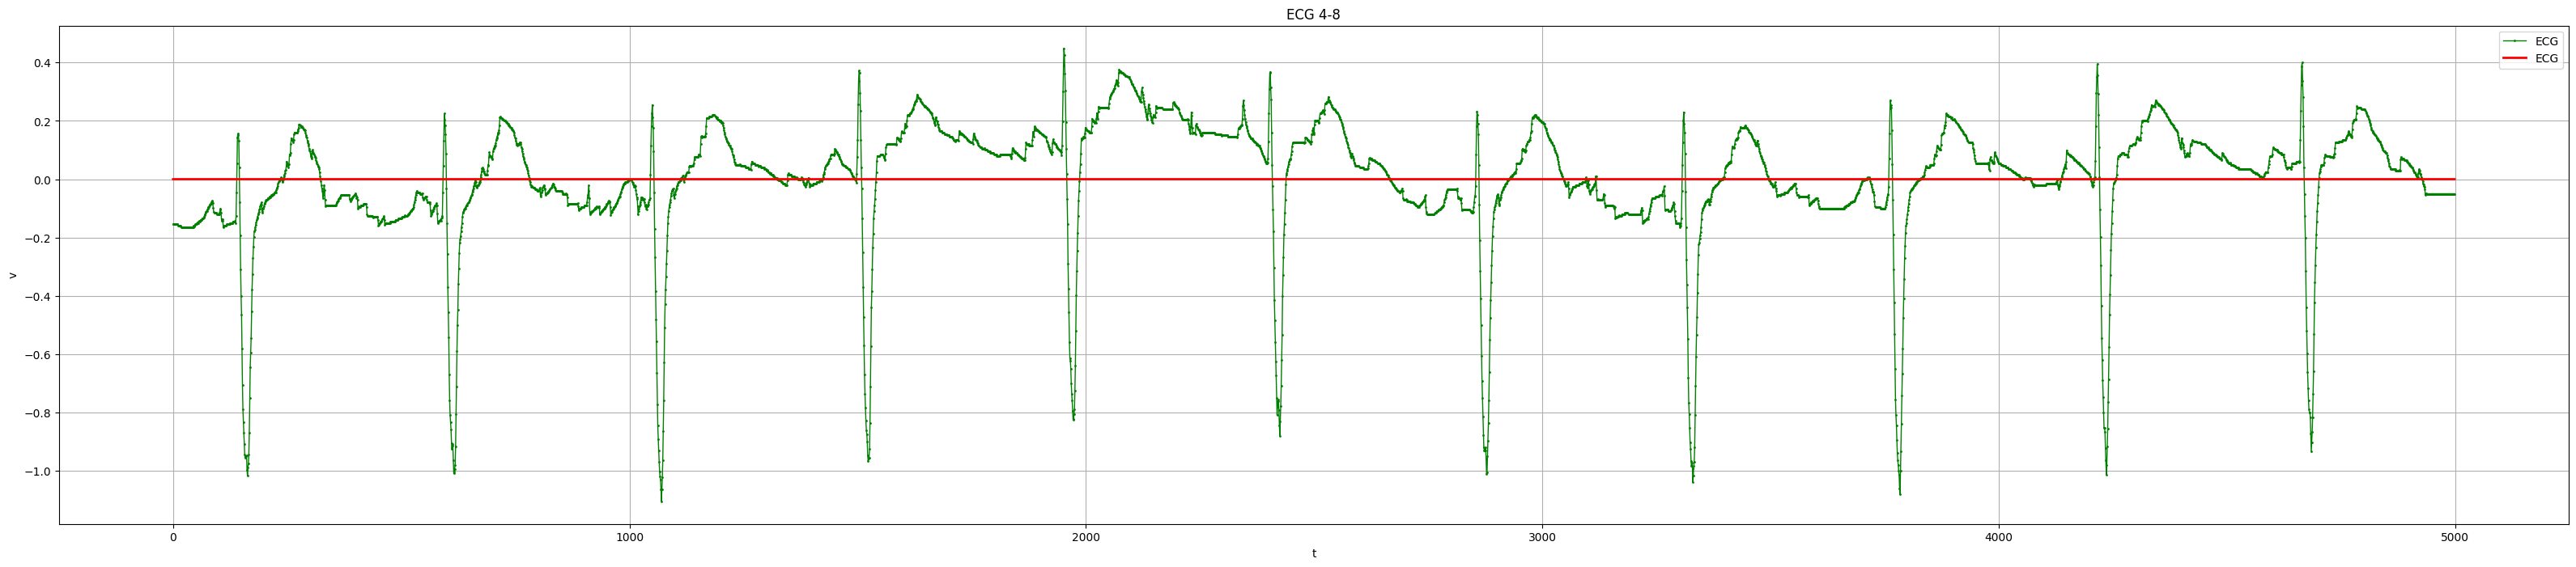

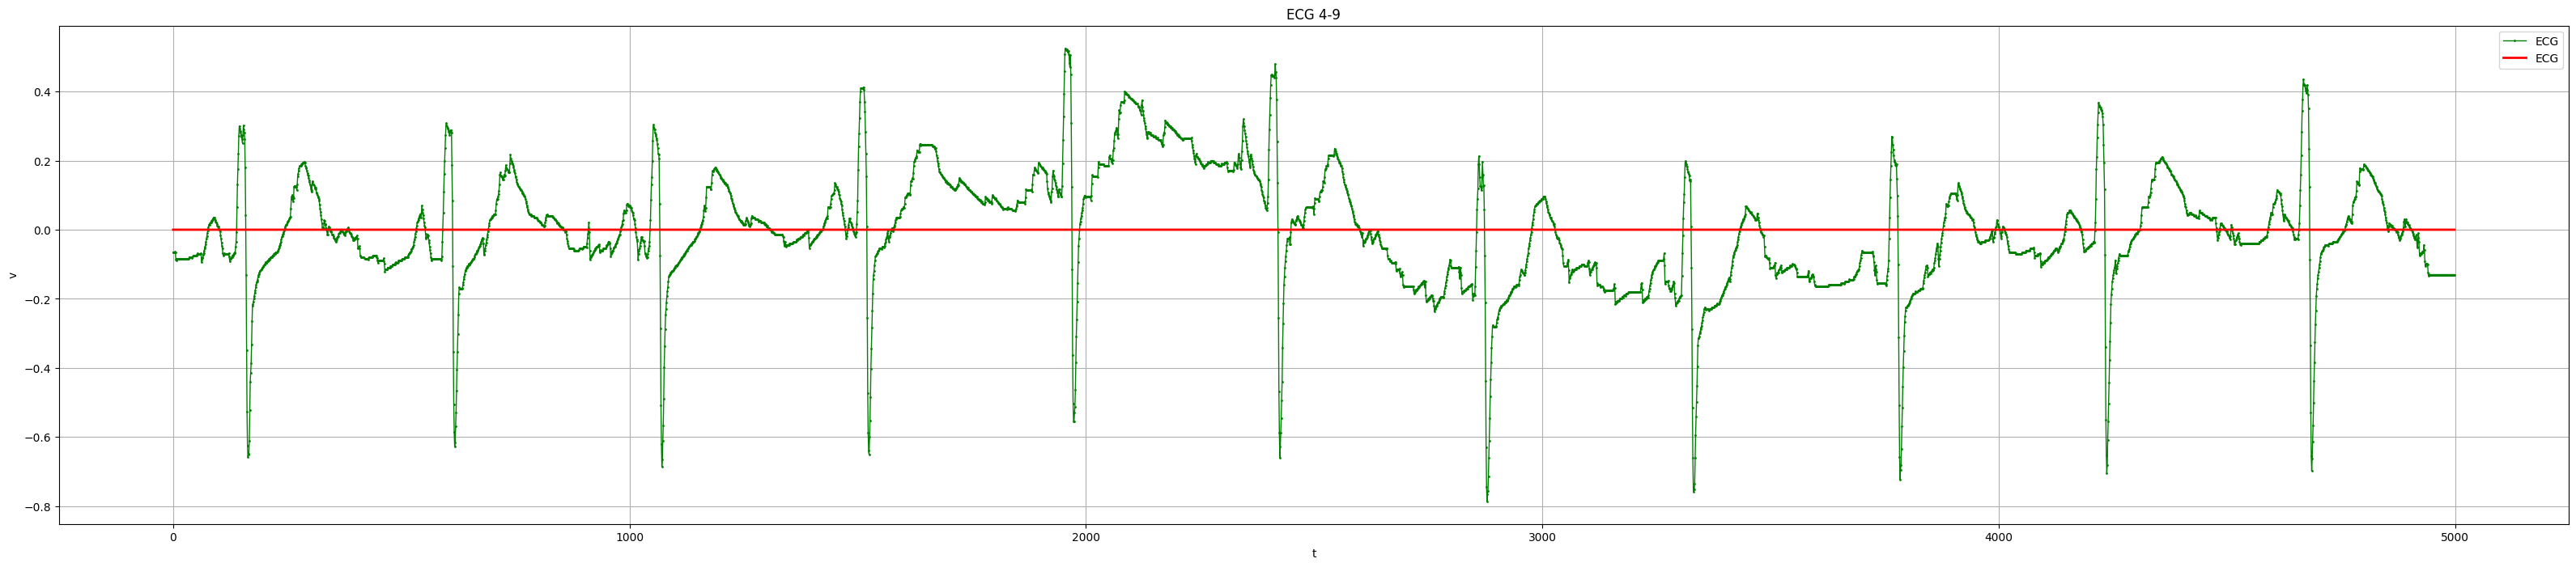

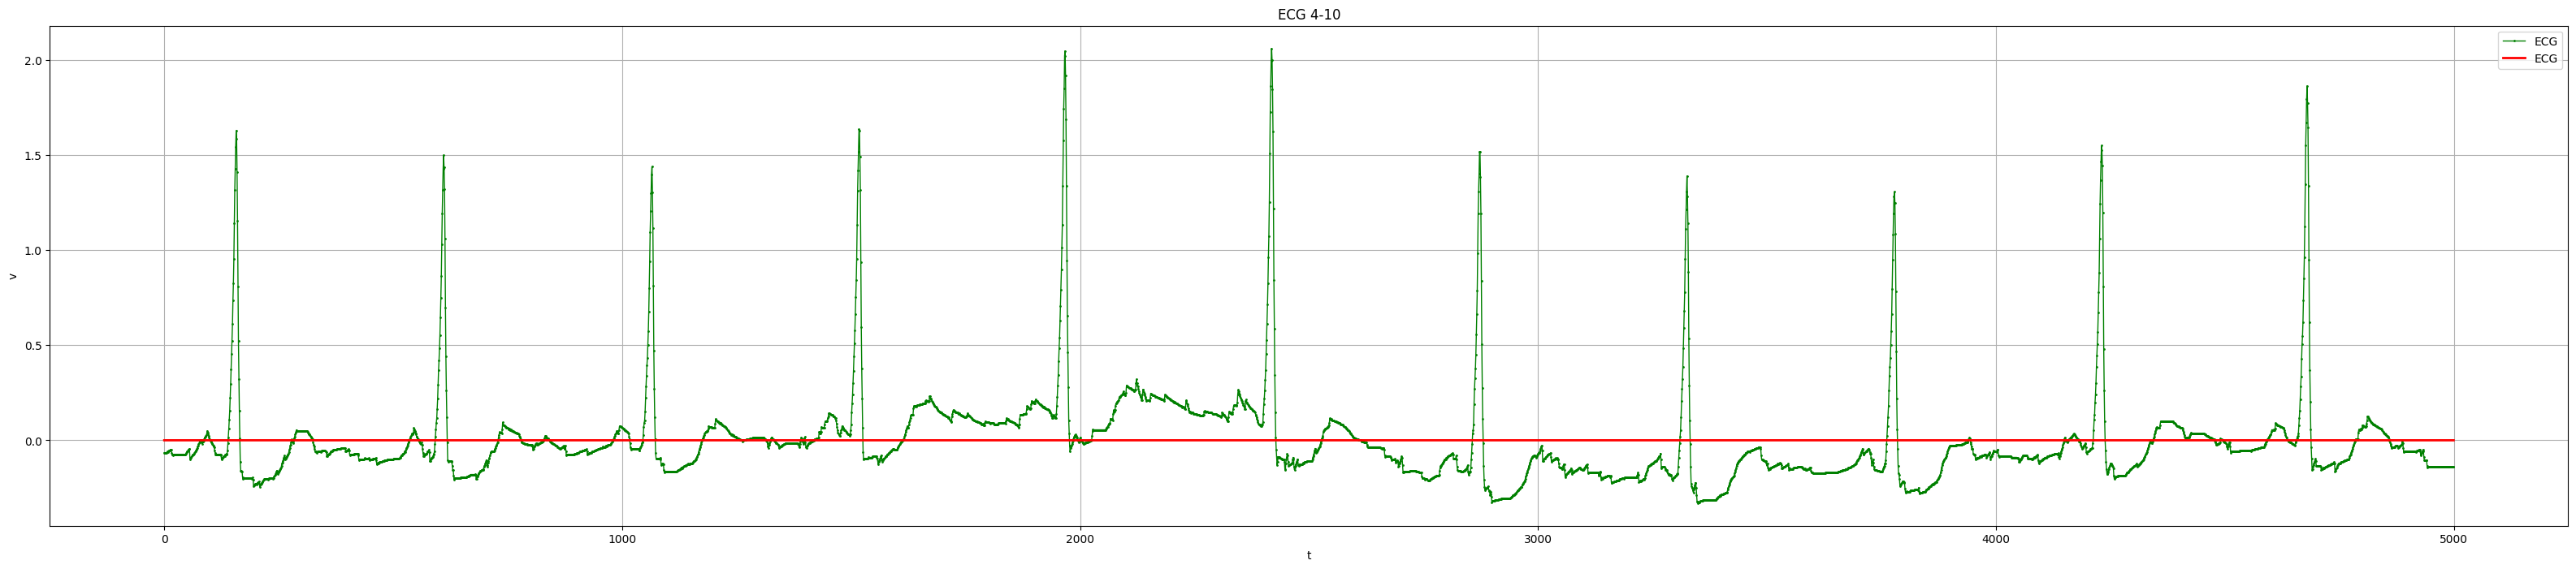

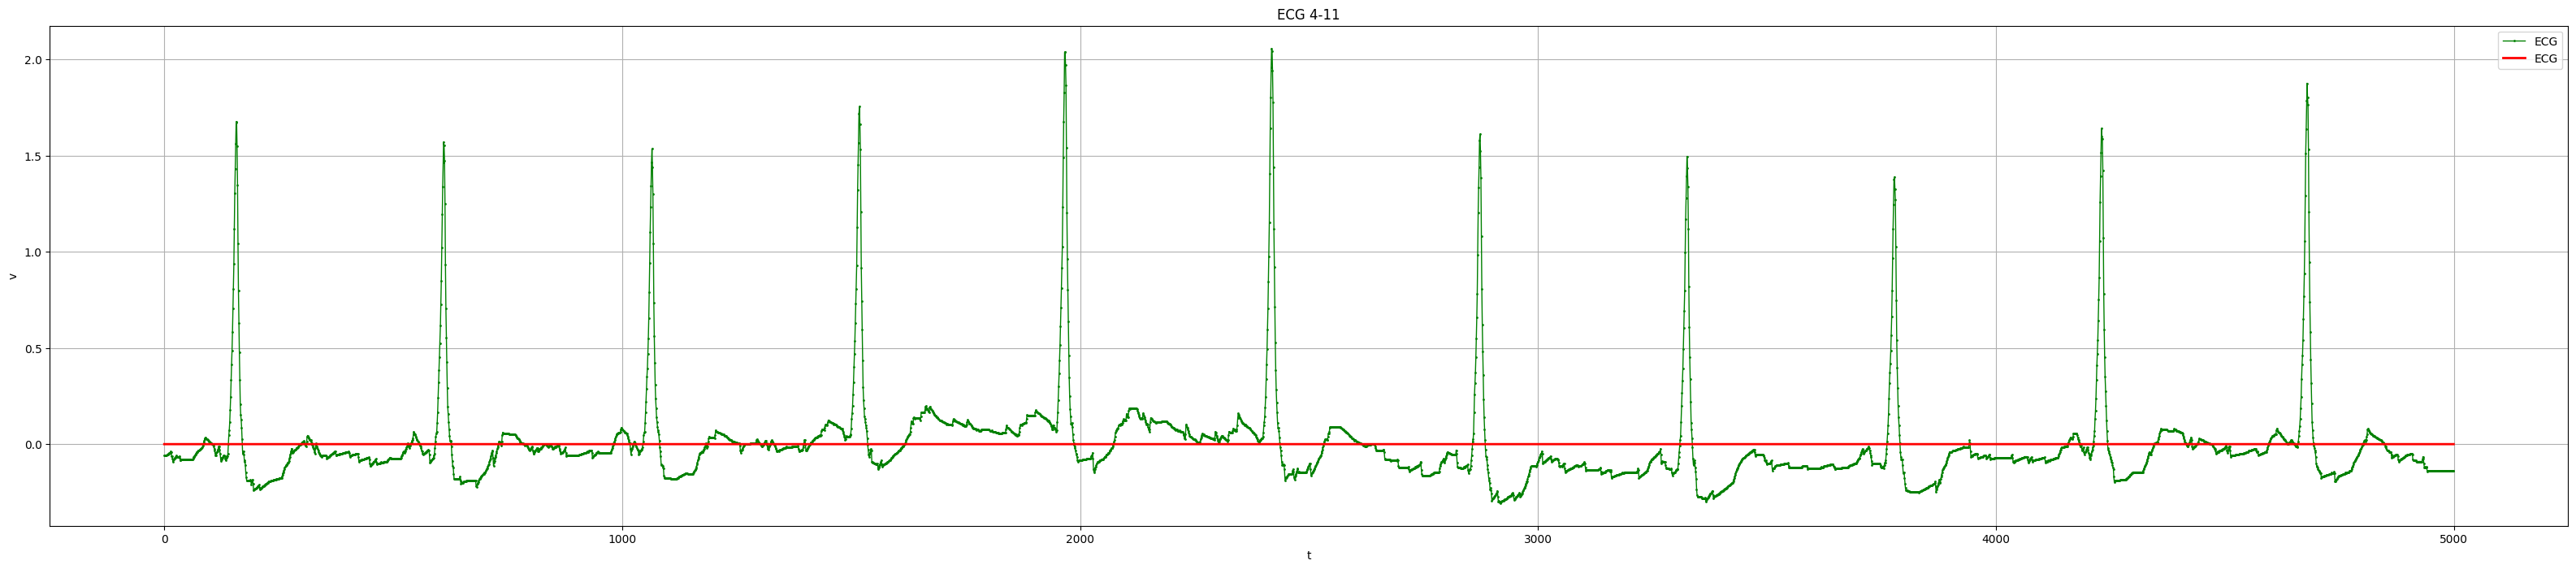

In [ ]:
# Визуализация ЭКГ | ECG Visualization
person=4
ll = new_signals["signal"].iloc[person].astype(list)

for i in range(len(ll)):
    plt.figure(figsize=(40, 8))
    plt.title(f'ECG {person}-{i}')
    plt.plot(list(ll[i]), 'go', linewidth=1, markersize=1, linestyle='-',
            label='ECG')
    plt.plot([0]*len(ll[i]), 'r', linewidth=2, markersize=0, linestyle='-',
            label='ECG')
    plt.grid(visible=True, which='both', axis='both')

    plt.xlabel('t')
    plt.ylabel('v')
    plt.legend()
    plt.show();

In [ ]:
new_cv = model.predict(tf.convert_to_tensor(list(new_signals["signal"])))>0.5

new_cv_df = pd.DataFrame({"record_name":new_signals["record_name"], "myocard":new_cv.astype(int)[:,0]})
new_cv_df.set_index("record_name", inplace=True)

15/15 [==============================] - 2s 76ms/step


In [ ]:
new_cv_df.to_csv("test_gts_only_ecg.csv")